# Spectroscopy Calibration

In [15]:
import glob
from astropy.io import fits
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm, SymLogNorm

# ignore annoying astropy warnings
import warnings
from astropy.utils.exceptions import AstropyWarning
warnings.simplefilter('ignore', category=AstropyWarning)

plt.style.use('seaborn-notebook') # Make the default figure settings a bit bigger
%matplotlib inline

from spectral_flat_tools import make_spectral_flats

## Bias

In [5]:
# Create a filepath "glob" (list) of all bias frames
bias_subdir = 'bias/'
bias_files = glob.glob(bias_subdir+'*.fits')

bias_data = [fits.getdata(b) for b in bias_files]
master_bias = np.median(bias_data, axis=0)  # axis=0 retains the shape of the original array

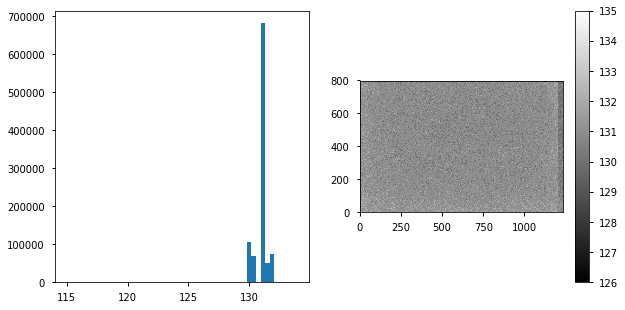

In [9]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(10,5))
hist = ax1.hist(master_bias.flatten(), bins=50)
img = plt.imshow(master_bias, cmap='gray', vmin=126, vmax=135, origin='lower')#,ax=ax2)
plt.colorbar();

In [10]:
master_bias_head = fits.getheader(bias_files[0])
fits.writeto('master_bias.fits', master_bias, header=master_bias_head, overwrite=True)

## Flats

In [11]:
flat_subdir = 'flats/'
flat_files = glob.glob(flat_subdir+'*.fits')

# Again, we need to remove the bias counts from all flat field exposures to 
# determine the contribution from just the flats
# flat_data = [fits.getdata(f)-master_bias for f in flat_files]
flat_data = [np.subtract(fits.getdata(f),master_bias) for f in flat_files]
master_flat = np.median(flat_data, axis=0)
master_flat = master_flat/np.median(master_flat)

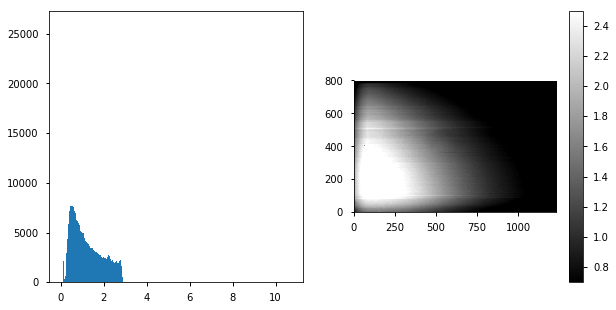

In [12]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(10,5))
hist = ax1.hist(master_flat.flatten(), bins=1000)
img = plt.imshow(master_flat, cmap='gray',vmin=0.7, vmax=2.5, origin='lower')
plt.colorbar();

In [13]:
master_flat_head = fits.getheader(flat_files[0])
fits.writeto('master_flat.fits', master_flat, 
             header=master_flat_head, overwrite=True)

## Spectral Flats

In [60]:
subregion = [[0, 1200, 0, 100],
            [0, 1200, 101, 200],
            [0, 1200, 201, 301],
            [0, 1200, 301, 400],
            [0, 1200, 401, 500],
            [0, 1200, 501, 600],
            [0, 1200, 601, 700],
            [0, 1200, 701, 725],
            [0, 1200, 726, 750]] # list of lists (for functionality with multiple regions)
                              # Each list has the form [xmin, xmax, ymin, ymax]
                              # Make sure your regions are large enough for both your spectrum and for estimation
                              # of sky background!
            
corrected_flatfield = make_spectral_flats(master_flat, subregion)
fits.writeto('master_flat_corrected.fits', corrected_flatfield, 
             header=master_flat_head, overwrite=True)

Done with subregion 1
Done with subregion 2
Done with subregion 3
Done with subregion 4
Done with subregion 5
Done with subregion 6
Done with subregion 7
Done with subregion 8
Done with subregion 9


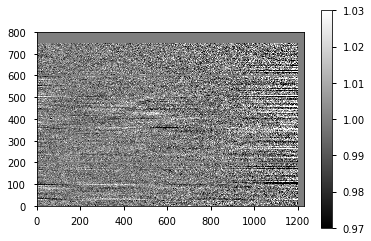

In [61]:
img = plt.imshow(corrected_flatfield, cmap='gray',vmin=0.97, vmax=1.03, origin='lower')
plt.colorbar();

## Calibration

In [62]:
science_files = glob.glob("science/raw/"+'*.fits')
science_data = [fits.getdata(s) for s in science_files]

calibrated_data = [(s - master_bias)/ corrected_flatfield for s in science_data]

In [64]:
calibrated_data_head = fits.getheader(science_files[0])
order = [10, 11, 122, 121, 13, 14, 152, 151, 2, 3, 4, 5, 6, 7, 8, 9] # 121 and 151 are primaries, 122 and 152 are secondaries
for i in range(len(calibrated_data)):
    index = order[i]
    fits.writeto('science/calibrated/calibrated_%d.fits' % index, calibrated_data[i], 
                 header=calibrated_data_head, clobber=True)

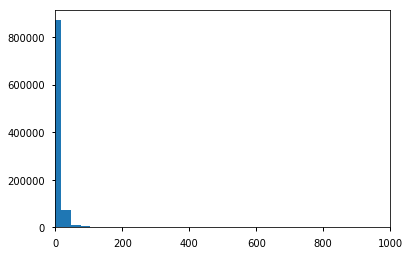

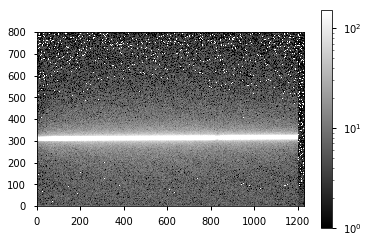

In [65]:
# vmin and vmax can be determined by plotting a histogram of the flattened image data
plt.hist(calibrated_data[0].flatten(), bins = 1000)
plt.xlim(0, 1000)
plt.show()

plt.imshow(calibrated_data[0], cmap='gray', norm=LogNorm(), vmin=1, vmax=150,origin='lower')
plt.colorbar();